## **Mount Google Drive to store files & data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing Python Packages for GAN**


In [2]:
# from keras.datasets import cifar10, mnist
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D, Dense, Conv2DTranspose
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
import numpy as np
!mkdir generated_images resized_images

In [3]:
images_path = "/content/drive/MyDrive/bobross/"

## **Resizing Data to match Neural Network Input**

In [4]:

import os
import cv2
reshape_size = (64,64)

i = 0
for image in os.listdir(images_path):
  img = cv2.imread(images_path + image)
  img = cv2.resize(img, reshape_size)
  cv2.imwrite("resized_images/%d.png" % i,img)
  
  i = i+1


## **Parameters for Neural Networks & Data**

In [5]:
img_width = 64
img_height = 64
channels = 3
img_shape = (img_width, img_height, channels)
latent_dim = 100
adam = Adam(lr=0.0002)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## **Building Generator**





In [6]:
def build_generator():
    model = Sequential()
    model.add(Dense(256 * 8* 8, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8,8,256)))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  
    model.summary()

    return model

generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                              

## **Building Discriminator**

In [7]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), padding='same', ))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()
    return model

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 256)      

In [8]:
generator.load_weights("/content/drive/MyDrive/generator10hour.h5")
discriminator.load_weights("/content/drive/MyDrive/discriminator10hour.h5")

## **Connecting Neural Networks to build GAN**

In [9]:
GAN = Sequential()
discriminator.trainable = False
GAN.add(generator)
GAN.add(discriminator)

GAN.compile(loss='binary_crossentropy', optimizer=adam)

## **Outputting Images**


In [10]:
import matplotlib.pyplot as plt
import glob
import imageio
import PIL

save_name = 0.00000000

def save_imgs(epoch):
    r, c = 4, 4
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)
    global save_name
    save_name += 0.00000001

    # Rescale images 0 - 1
    gen_imgs = (gen_imgs + 1) / 2.0

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("currentgeneration.png")
    fig.savefig("generated_images/%.8f.png" % save_name)
    plt.close()

## **Training GAN**

In [11]:
from PIL import Image

def train(epochs, batch_size=32, save_interval=200):

  array = []
  #PUT PATH OF RESIZED IMAGES
  path = "/content/resized_images/"

  for dir in os.listdir(path):
            
    image = Image.open(path + dir)
    data = np.asarray(image)
    array.append(data)

  X_train = np.array(array)
  print(X_train.shape)

  
  #Rescale data between -1 and 1
  X_train = X_train / 127.5 -1.
  bat_per_epo = int(X_train.shape[0] / batch_size)
  
  print(X_train.shape)

  #Creating Y for the Neural Networks
  valid = np.ones((batch_size, 1))
  fakes = np.zeros((batch_size, 1))

  for epoch in range(epochs):
    for j in range(bat_per_epo):
      #Getting Random Batch
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]

      #Generating Fake Images
      noise = np.random.normal(0, 1, (batch_size, latent_dim))
      gen_imgs = generator.predict(noise)

      #Training discriminator
      d_loss_real = discriminator.train_on_batch(imgs, valid)
      d_loss_fake = discriminator.train_on_batch(gen_imgs, fakes)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      noise = np.random.normal(0, 1, (batch_size, latent_dim))
      
      #inverse y label
      g_loss = GAN.train_on_batch(noise, valid)

      print("******* %d %d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch,j, d_loss[0], 100* d_loss[1], g_loss))

      
    save_imgs(epoch)


train(30000, batch_size=32, save_interval=200)

******* 70 5 [D loss: 0.446949, acc: 87.50%] [G loss: 8.917387]
******* 70 6 [D loss: 0.022326, acc: 98.44%] [G loss: 10.378748]
******* 70 7 [D loss: 0.085781, acc: 95.31%] [G loss: 12.186899]
******* 70 8 [D loss: 0.118615, acc: 98.44%] [G loss: 12.928574]
******* 70 9 [D loss: 0.115626, acc: 93.75%] [G loss: 10.208775]
******* 70 10 [D loss: 0.216279, acc: 95.31%] [G loss: 9.361361]
******* 70 11 [D loss: 0.112092, acc: 95.31%] [G loss: 8.338655]
******* 70 12 [D loss: 0.160844, acc: 92.19%] [G loss: 4.626344]
******* 70 13 [D loss: 0.156246, acc: 95.31%] [G loss: 6.224194]
******* 70 14 [D loss: 0.235983, acc: 95.31%] [G loss: 6.576787]


KeyboardInterrupt: ignored

In [14]:
noise = np.random.normal(0, 1, (100, latent_dim))
gen_imgs = generator.predict(noise)
gen_imgs = (gen_imgs + 1) / 1.63


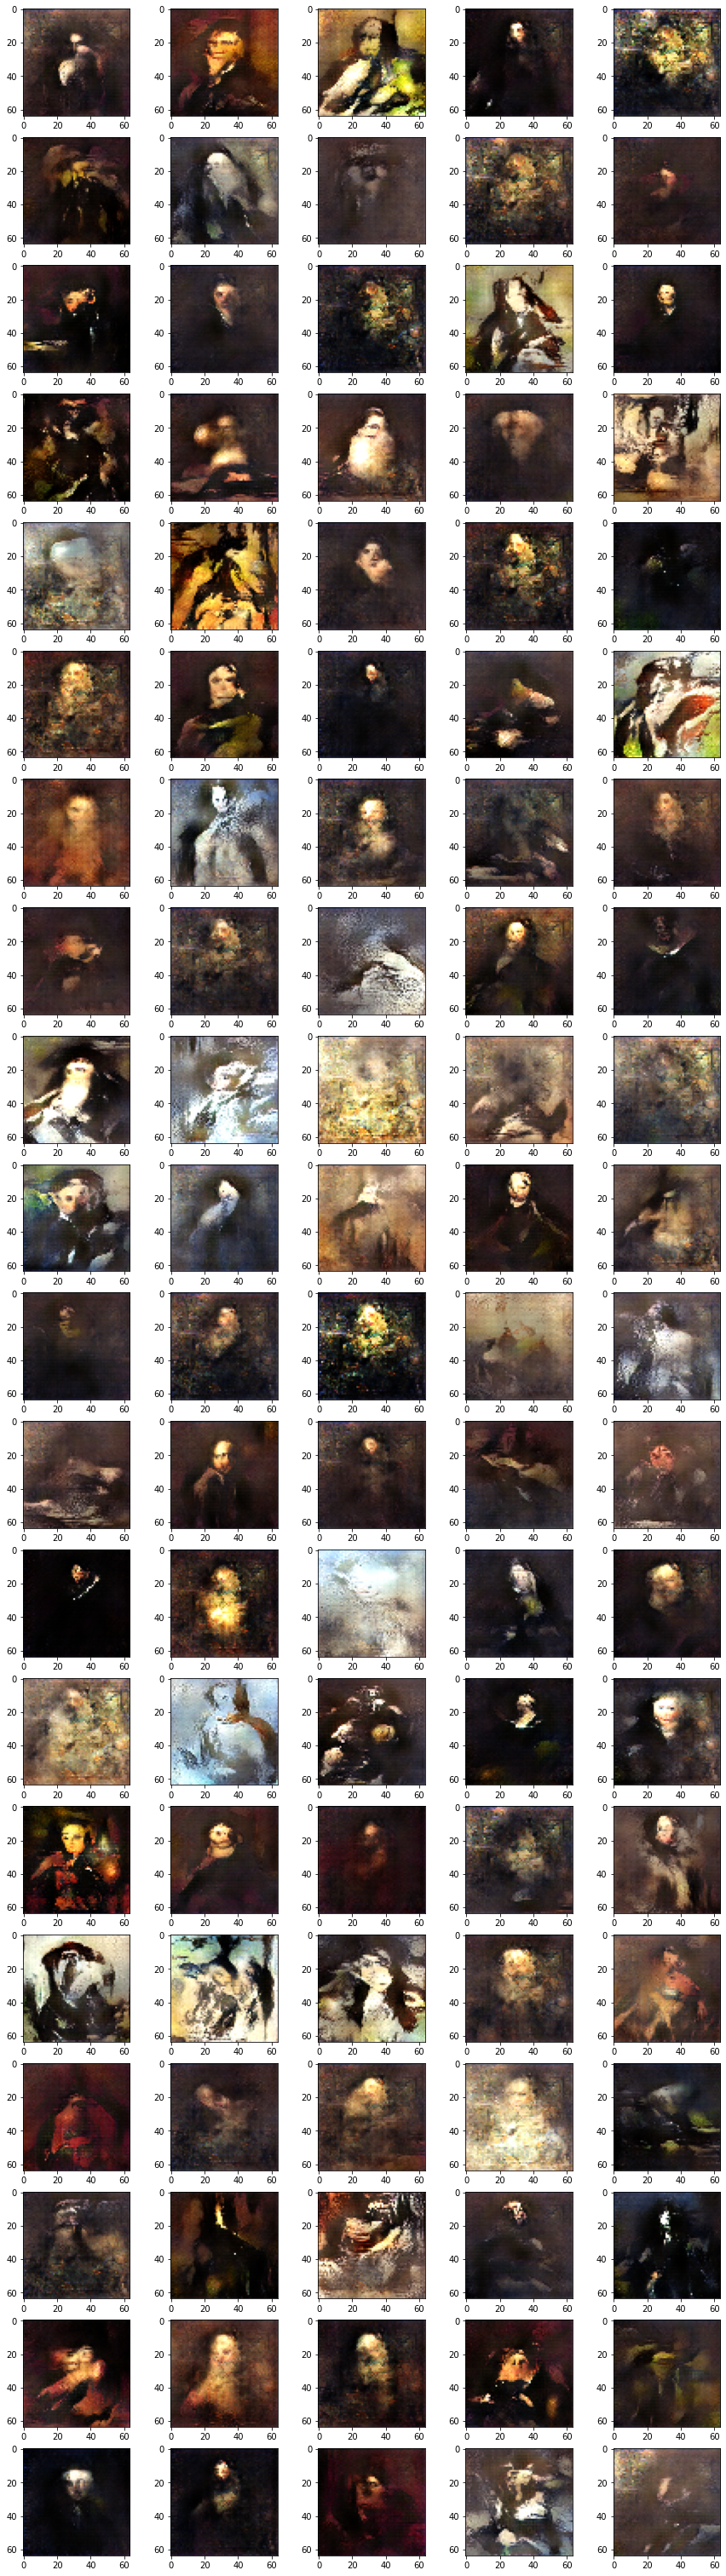

In [15]:
plt.figure(figsize=(15,55),facecolor='white')
plotnum=1
for i in range(0,100):
    if plotnum<=100:
        plt.subplot(20,5,plotnum)
        plt.imshow(gen_imgs[i])
        
    plotnum+=1
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


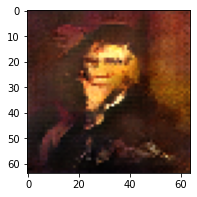

In [23]:
plt.figure(figsize=(3,3),facecolor='white')
plt.imshow(gen_imgs[1])

In [17]:
generator.save_weights("/content/drive/MyDrive/generator11hour.h5")
discriminator.save_weights("/content/drive/MyDrive/discriminator11hour.h5")

### **8) Making GIF**

In [18]:


anim_file = 'paintergan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('generated_images/*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)